> Jiri Pik, Sourav Ghosh, Hands-On Financial Trading with Python, Packt, 2021

## Statistical Estimation, Inference, and Prediction

In [63]:
# Import modules
import numpy as np
import pandas as pd

from datetime import datetime, date
from math import sqrt, ceil

from matplotlib import pyplot as plt

# File system directory/file browsing and location.
import glob
import os

import statsmodels.api as sm
# Normal distribution test
from statsmodels.graphics.api import qqplot

In [64]:
# Constants and Global Variables

# CONSTANTS AND GLOBAL VARIABLES

# [ACTIONS REQUIRED BEFORE RUNNING THIS SCRIPT]:
# 1. Download security data by running Price Data Download.ipynb
# 2. Change security variable below as needed.
# securities = ['TQQQ', 'UPRO', 'FB', 'AAPL' , 'PLTR', 'GPRO', 'C']
# securities = ['DOW', 'CSX', 'VZ', 'CSCO', 'WFC', 'NEM', 'AFL']
# securities = ['QQQ', 'SPY']

# Security
security = 'SPY'

In [65]:
# Functions

# Calculated Price Spikes in Standard Deviation
def calc_price_spikes_annual_vol(df, window=20, yearly_trading_period=252):
    # Calculate Price Spikes and Annual Volatility
    # df = daily or minute price data
    # window = sliding window to use for calculating standard deviation
    # yearly_trading_period = Number of trading periods in a year
    #   For daily pricing data, it is number of trading days in a year = 252
    #   For 2 minute pricing data, it is number of 2 minutes trading intervals in a year
    #   2 minute interval per year = 252 days x 24 hours x 30 per hour = 181,440

    # Reset index before calculations otherwise warnings are issued
    index_name = df.index.name
    df = df.reset_index()
    
    # Calculate Log Change from previous day
    df['LogChng'] = np.log(df.Close / df.Close.shift(1))
    
    # Standard Deviation of LogChng over a specified time period (sliding window)
    # The value calculated is equal to standard deviation of the logs 
    # of the X most recent price changes (Column B) multiplied by the closing
    # price on current day. It represents, in dollar and cents, the value of 
    # a 1-day 1 StdDev price change.
    df['StdDevLog'] = df.LogChng.rolling(window).std() * df.Close
    
    # Price Spikes in terms of Standard Deveiation
    df['Spikes'] = (df.Close - df.Close.shift(1)) / df.StdDevLog.shift(1)

    # Calculate Annualized Volatility from Standard Deviation of Log Change over sliding Window
    # Annual Volatility
    # Number of trading periods in a year.
    # For daily pricing data, trading days in a year
    # For 1 minute pricing data, trading minutes in a year
    df['AnnVol'] = df.StdDevLog * sqrt(yearly_trading_period)
    
    # Change Index back to original column
    df = df.set_index(index_name)
    
    return df

In [66]:
# Get daily security price data from Yahoo! Finance

data_type = 'daily'
# get latest data file for specified security
file_name = max(glob.iglob('data/{}_{}_*.csv'.format(security, data_type)), key=os.path.getctime)
price_df = pd.read_csv(file_name, index_col=0, parse_dates=True, infer_datetime_format=True)

In [67]:
# Calculate Price Spike in Standard Deviation and Annual Volatility
window = 20
trading_period = 252
price_df = calc_price_spikes_annual_vol(price_df, window=window, \
                                        yearly_trading_period=trading_period)
price_df.head()

,High,Low,Open,Close,Volume,Adj Close,LogChng,StdDevLog,Spikes,AnnVol
Date,,,,,,,,,,
2021-03-11,395.649994,391.739990,392.230011,393.529999,86245000.0,388.353302,NaN,NaN,NaN,NaN
2021-03-12,394.209991,391.200012,392.070007,394.059998,64653600.0,388.876343,0.001346,NaN,NaN,NaN
2021-03-15,396.690002,392.029999,394.329987,396.410004,73427200.0,391.195435,0.005946,NaN,NaN,NaN
2021-03-16,397.829987,395.079987,397.070007,395.910004,73722500.0,390.702026,-0.001262,NaN,NaN,NaN
2021-03-17,398.119995,393.299988,394.529999,397.260010,97959300.0,392.034271,0.003404,NaN,NaN,NaN


## Introduction to statsmodels

### Normal distribution test with Q-Q models

An underlying assumption of many statistical learning techniques is the normal distribution of observation. An intuitive visual method to test for normality is quantile-quantile plot (Q-Q plot). If a sample is normally distributed, its Q-Q plot is a straight line.

Q-Q plots are used for comparison between two probability distributions, with one of them being a normal distribution, by plotting their quantiles against one another.

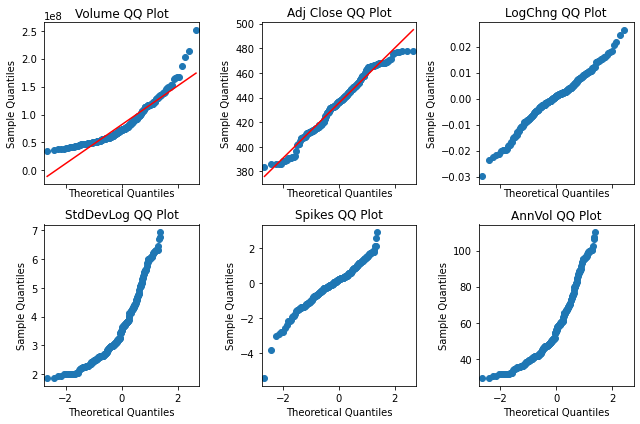

In [68]:
# Test various columns of price_df for normality
fig, axes = plt.subplots(ncols=3, nrows=2, sharex=True, figsize=(3*3, 2*3))
for k, ax in zip(price_df.columns[4:], np.ravel(axes)):
    qqplot(price_df[k], line='s', ax=ax)
    ax.set_title(f'{k} QQ Plot')
plt.tight_layout()

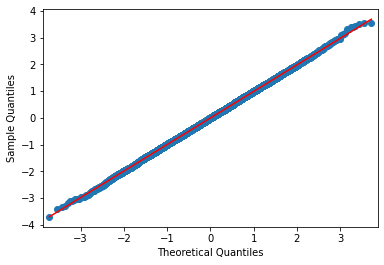

In [69]:
# A normal distribution
fig = qqplot(np.random.normal(size=10000), line='s')

### ETS analysis of a time series

The Error, Trend, Seasonality (ETS) analysis of time series breaks down the data into three components:

* The **trend** component captures the overall trend of the time series.
* The **seasonality** component captures cyclical/seasonal changes.
* The **error** component captures noise in the data that could not be captured with trend or seasonality components.

#### The Hodrick-Prescott filter

It is used to separate the trend and cyclical components from time series data by removing short term fluctuations from long term trend.

In [70]:
hp_cycle, hp_trend = sm.tsa.filters.hpfilter(price_df.Close, lamb=6.25)
decomp = decomp.assign(Close = price_df.Close)
decomp['HP_Cycle'] = hp_cycle
decomp['HP_Trend'] = hp_trend
decomp

,Close,HP_Cycle,HP_Trend,UC_Cycle,UC_Trend,UC_Error
Date,,,,,,
2021-03-11,393.529999,-1.006321,394.536320,-0.790468,394.321713,393.529999
2021-03-12,394.059998,-0.873636,394.933634,-0.516553,394.749205,122.669235
2021-03-15,396.410004,1.240068,395.169936,0.398687,395.508163,149.355177
2021-03-16,395.910004,0.965570,394.944433,0.818648,395.301027,-157.402422
2021-03-17,397.260010,3.105266,394.154744,0.222758,395.496528,5.784030
...,...,...,...,...,...,...
2022-03-04,432.170013,3.163470,429.006543,1.527582,429.276083,-4.359161
2022-03-07,419.429993,-6.582031,426.012024,-0.218416,422.464802,-12.205146
2022-03-08,416.250000,-7.833861,424.083861,-1.693551,421.061847,-4.377515


#### UnobservedComponents model

Another way of breaking down a time series into ETS components.

In [71]:
uc = sm.tsa.UnobservedComponents(np.asarray(price_df.Close), level='lltrend', cycle=True, stochastic_cycle=True)
res_uc = uc.fit(method='powell', disp=True)
res_uc.summary()

Optimization terminated successfully.
         Current function value: 2.804286
         Iterations: 8
         Function evaluations: 523


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      y   No. Observations:                  253
Model:             local linear trend   Log Likelihood                -709.484
                   + stochastic cycle   AIC                           1428.969
Date:                Mon, 14 Mar 2022   BIC                           1446.556
Time:                        15:10:16   HQIC                          1436.048
Sample:                             0                                         
                                - 253                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     4.5975      1.195      3.847      0.000       2.255       6.940
sigma2.level         8.8265      1.353      6.523      0.000       6.174      11.479
sigma2.trend         0.0032      0.004      0.752      0.452      -0.005       0.012
sigma2.cycle         0.0030      0.008      0.386      0.700      -0.012       0.018
frequency.cycle      1.1818      0.006    196.762      0.000       1.170       1.194
===================================================================================
Ljung-Box (L1) (Q):                  17.26   Jarque-Bera (JB):                 4.18
Prob(Q):                              0.00   Prob(JB):                         0.12
Heteroskedasticity (H):               3.69   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
# Add ETS components to decomp df

decomp['UC_Cycle'] = res_uc.cycle.smoothed
decomp['UC_Trend'] = res_uc.level.smoothed
decomp['UC_Error'] = res_uc.resid
decomp

,Close,HP_Cycle,HP_Trend,UC_Cycle,UC_Trend,UC_Error
Date,,,,,,
2021-03-11,393.529999,-1.006321,394.536320,-0.790468,394.321713,393.529999
2021-03-12,394.059998,-0.873636,394.933634,-0.516553,394.749205,122.669235
2021-03-15,396.410004,1.240068,395.169936,0.398687,395.508163,149.355177
2021-03-16,395.910004,0.965570,394.944433,0.818648,395.301027,-157.402422
2021-03-17,397.260010,3.105266,394.154744,0.222758,395.496528,5.784030
...,...,...,...,...,...,...
2022-03-04,432.170013,3.163470,429.006543,1.527582,429.276083,-4.359161
2022-03-07,419.429993,-6.582031,426.012024,-0.218416,422.464802,-12.205146
2022-03-08,416.250000,-7.833861,424.083861,-1.693551,421.061847,-4.377515


#### Seasonal decompose method